# Florence-2-large sample usage

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
%matplotlib inline  

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

## define the prediction function

In [13]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image 

In [14]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

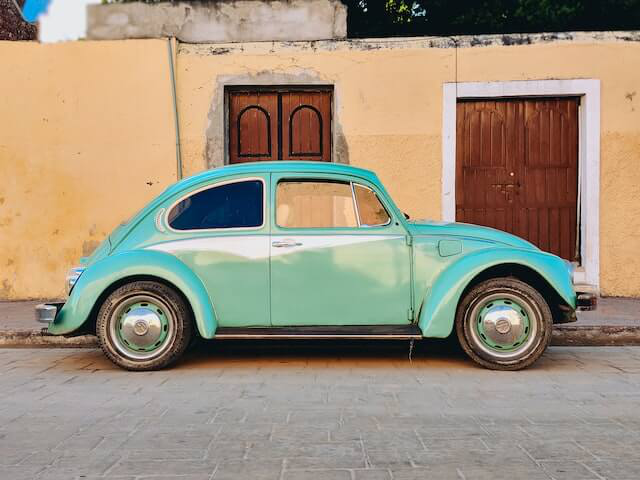

In [15]:
image

## Run pre-defined tasks without additional inputs 

### Caption

In [16]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [17]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a blue Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [18]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a sleek, streamlined design. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

### Object detection

OD results format: 
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...], 
    'labels': ['label1', 'label2', ...]
    } 
}

In [21]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.23999786376953, 580.7999877929688, 261.8399963378906], [224.95999145507812, 86.15999603271484, 333.7599792480469, 164.39999389648438], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.3199768066406], [91.19999694824219, 280.0799865722656, 198.0800018310547, 370.3199768066406]], 'labels': ['car', 'door', 'door', 'wheel', 'wheel']}}


In [22]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

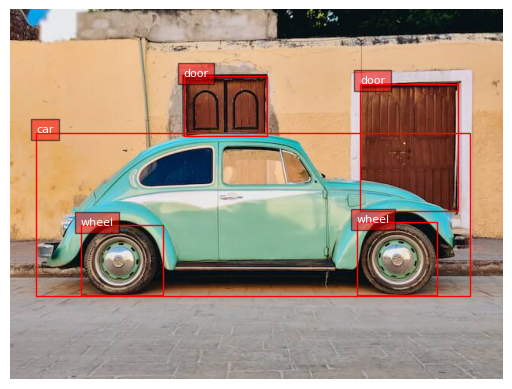

In [24]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format: 
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [25]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.72000122070312, 580.1599731445312, 261.8399963378906], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.79998779296875], [91.83999633789062, 280.0799865722656, 198.0800018310547, 370.79998779296875], [224.95999145507812, 86.15999603271484, 333.7599792480469, 164.39999389648438]], 'labels': ['turquoise Volkswagen Beetle', 'wooden double doors with metal handles', 'wheel', 'wheel', 'door']}}


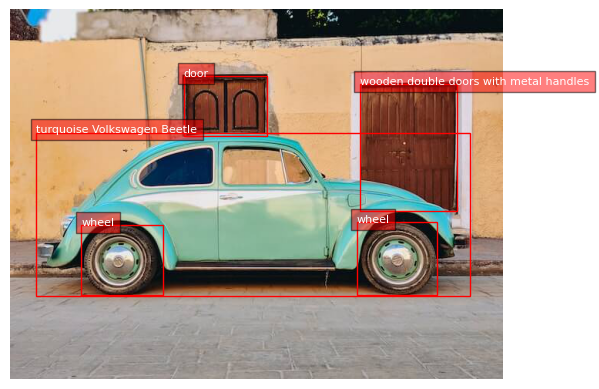

In [27]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format: 
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [28]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 159.59999084472656, 596.7999877929688, 371.7599792480469], [454.0799865722656, 96.23999786376953, 580.7999877929688, 261.8399963378906], [449.5999755859375, 276.239990234375, 554.5599975585938, 370.3199768066406], [91.19999694824219, 280.0799865722656, 198.0800018310547, 370.3199768066406], [224.3199920654297, 85.19999694824219, 333.7599792480469, 164.39999389648438], [274.239990234375, 178.8000030517578, 392.0, 228.239990234375], [165.44000244140625, 178.8000030517578, 264.6399841308594, 230.63999938964844]], 'labels': ['', '', '', '', '', '', '']}}


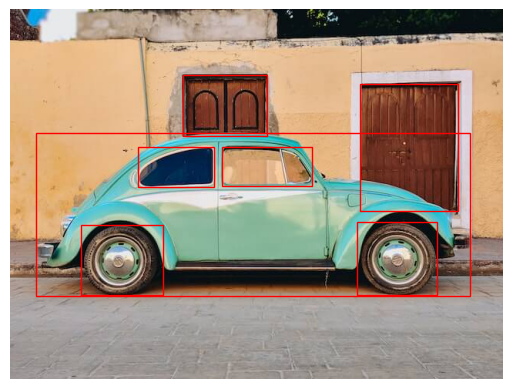

In [29]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs 

### Phrase Grounding
Phrase grounding results format: 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [30]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.23999786376953, 159.1199951171875, 582.0800170898438, 374.6399841308594], [1.5999999046325684, 4.079999923706055, 639.0399780273438, 305.03997802734375]], 'labels': ['A green car', 'a yellow building']}}


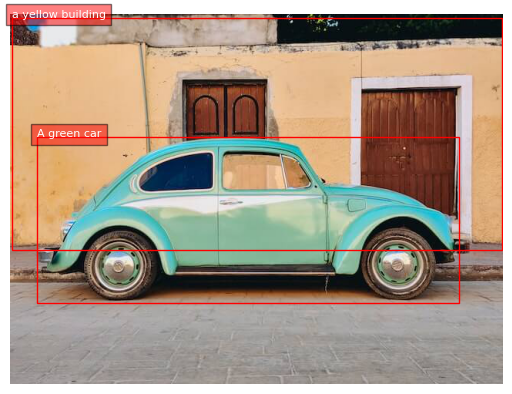

In [31]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format: 
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [32]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[180.8000030517578, 180.72000122070312, 182.72000122070312, 180.72000122070312, 187.83999633789062, 177.83999633789062, 189.75999450683594, 177.83999633789062, 192.95999145507812, 175.9199981689453, 194.87998962402344, 175.9199981689453, 198.0800018310547, 174.0, 200.63999938964844, 173.0399932861328, 203.83999633789062, 172.0800018310547, 207.0399932861328, 170.63999938964844, 209.59999084472656, 169.67999267578125, 214.0800018310547, 168.72000122070312, 217.9199981689453, 167.75999450683594, 221.75999450683594, 166.8000030517578, 226.239990234375, 165.83999633789062, 230.72000122070312, 164.87998962402344, 237.1199951171875, 163.9199981689453, 244.1599884033203, 162.95999145507812, 253.1199951171875, 162.0, 265.2799987792969, 161.0399932861328, 312.6399841308594, 161.0399932861328, 328.6399841308594, 162.0, 337.6000061035156, 162.95999145507812, 344.6399841308594, 163.9199981689453, 349.7599792480469, 164.87998962402344, 353.6000

In [33]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

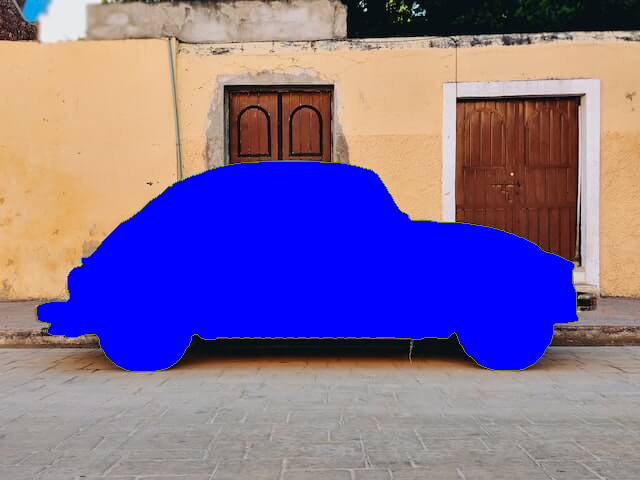

In [34]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999]. 

In [35]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[468.79998779296875, 288.239990234375, 472.6399841308594, 285.3599853515625, 475.8399963378906, 283.44000244140625, 477.7599792480469, 282.47998046875, 479.67999267578125, 282.47998046875, 482.8799743652344, 280.55999755859375, 485.44000244140625, 279.6000061035156, 488.6399841308594, 278.6399841308594, 491.8399963378906, 277.67999267578125, 497.5999755859375, 276.7200012207031, 511.67999267578125, 276.7200012207031, 514.8800048828125, 277.67999267578125, 518.0800170898438, 278.6399841308594, 520.6400146484375, 280.55999755859375, 522.5599975585938, 280.55999755859375, 524.47998046875, 282.47998046875, 527.6799926757812, 283.44000244140625, 530.8800048828125, 285.3599853515625, 534.0800170898438, 287.2799987792969, 543.0399780273438, 296.3999938964844, 544.9599609375, 299.2799987792969, 546.8800048828125, 302.1600036621094, 548.7999877929688, 306.47998046875, 548.7999877929688, 308.3999938964844, 550.719970703125, 311.2799987792969, 552.0, 31

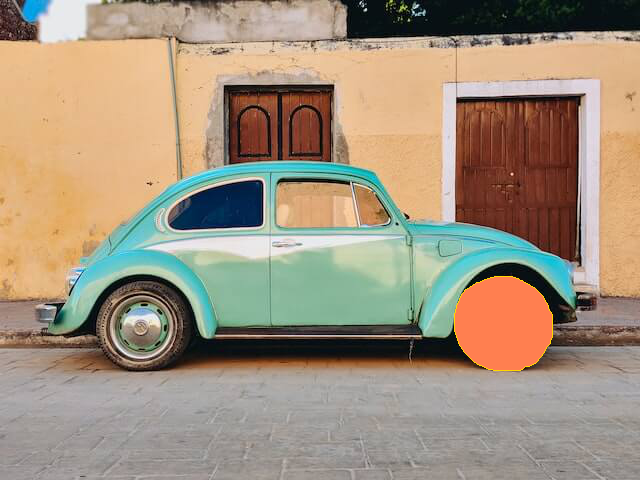

In [37]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)  

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts. 

results format: 

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [38]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 582.0800170898438, 374.1600036621094]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [39]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

In [40]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

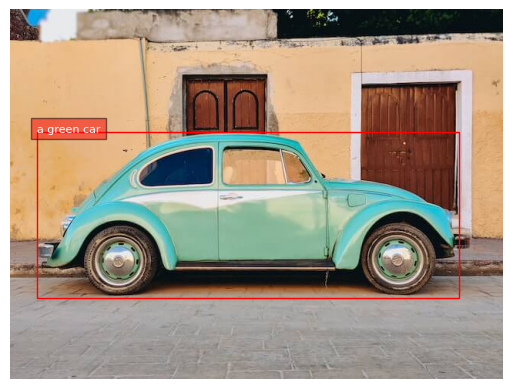

In [41]:
plot_bbox(image, bbox_results)

### region to texts

In [42]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [43]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [44]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

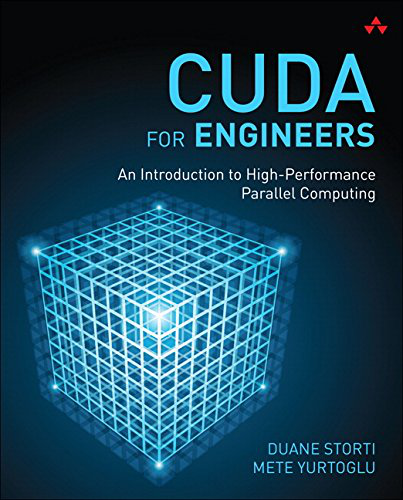

In [45]:
image

In [46]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDAFOR ENGINEERSAn Introduction to High-PerformanceParallel ComputingDUANE STORTIMETE YURTOGLU'}

In [49]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.0435028076172, 50.25, 375.7974853515625, 50.25, 375.7974853515625, 114.75, 167.0435028076172, 114.75], [144.8784942626953, 120.75, 375.7974853515625, 120.75, 375.7974853515625, 149.25, 144.8784942626953, 149.25], [115.86249542236328, 165.25, 376.6034851074219, 166.25, 376.6034851074219, 184.25, 115.86249542236328, 183.25], [239.9864959716797, 184.25, 376.6034851074219, 186.25, 376.6034851074219, 204.25, 239.9864959716797, 202.25], [266.1814880371094, 441.25, 376.6034851074219, 441.25, 376.6034851074219, 456.25, 266.1814880371094, 456.25], [252.0764923095703, 460.25, 376.6034851074219, 460.25, 376.6034851074219, 475.25, 252.0764923095703, 475.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [51]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
    display(image)


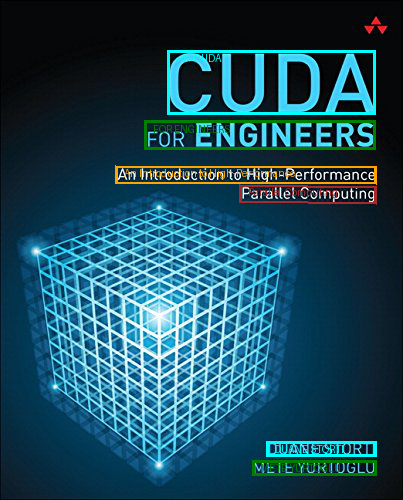

In [53]:
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])  